Soroosh Noorzad<br/>
99205372<br/>
winter of 1400

# Caption Generator:

In [1]:
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
%matplotlib inline

import string
import os
import glob
from PIL import Image
from time import time

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from keras import Input, layers
from keras import optimizers
from keras.preprocessing import sequence, image
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM, Embedding, Dense, Activation, Flatten, Reshape, Dropout
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.models import Model

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
def downloader_to_gdrive(link, base_path, file_name, zip, chunk_size = 1000):
  path = base_path + file_name
  import os
  isdir = os.path.isdir(path[:-4])
  if isdir:
    print(file_name[:-4], "folder already exists! Download skipped...")
  else:
    isFile = os.path.isfile(path)
    if isFile:
      print(file_name, "already exists! Download skipped...")
    else:
      import requests
      r = requests.get(link, stream = True)
      # 1 MB = 1024 * 1024 byte
      CS = chunk_size*1024*1024
      with open(path, "wb") as file: 
        print(file_name, "download started.")
        for i, block in enumerate(r.iter_content(chunk_size = CS)):
          print(".", end = "")
          # print((i+1)*chunk_size,"MB downloaded...")
          if block:
            file.write(block)
        print("\n" + file_name, "download finished.")
    if zip:
      print("Extracting started...")
      import zipfile
      with zipfile.ZipFile(path, 'r') as zip_ref:
        zip_ref.extractall(path[:-4])

base_path = "/content/drive/MyDrive/"

GLOVE_name = "glove.zip"
GLOVE_link = "https://nlp.stanford.edu/data/glove.6B.zip"
downloader_to_gdrive(GLOVE_link, base_path, GLOVE_name, True, 1000)

flk_dst_name = "flk_dst.zip"
flk_dst_link = "https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip"
downloader_to_gdrive(flk_dst_link, base_path, flk_dst_name, True, 1000)

flk_txt_name = "flk_txt.zip"
flk_txt_link = "https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip"
downloader_to_gdrive(flk_txt_link, base_path, flk_txt_name, True, 1000)

images_path = base_path + '/flk_dst/Flicker8k_Dataset/'
token_txt = base_path + "/flk_txt/Flickr8k.token.txt"
test_images_path = base_path + '/flk_txt/Flickr_8k.testImages.txt'
train_images_path = base_path + '/flk_txt/Flickr_8k.trainImages.txt'
glove_path = base_path + "/glove"
glove_txt = base_path + "/glove/glove.6B.200d.txt"

glove.zip download started.
.
glove.zip download finished.
Extracting started...
flk_dst.zip download started.
..
flk_dst.zip download finished.
Extracting started...
flk_txt.zip download started.
.
flk_txt.zip download finished.
Extracting started...


About Flick8k:
* Flick8k_Dataset: contains the 8000 images
* Flick8k_Text:
  * Flickr8k.token.txt: contains the image id along with the 5 captions
  * Flickr8k.trainImages.txt: contains the training image id’s
  * Flickr8k.testImages.txt: contains the test image id’s
<br/>
<br/>


In [12]:
# Read token file (3.24MB file) to create an organized and useful dictionary:
doc = open(token_txt,'r').read()
# descriptions dictionary:
# keys: name of the image 
# values: list of the 5 captions for the corresponding image
descriptions = dict()
# Split tokens line by line and throw the short lines away:
for line in doc.split('\n'):
  tokens = line.split()
  if len(line) > 2:
    image_id = tokens[0].split('.')[0]
    image_desc = ' '.join(tokens[1:])
    if image_id not in descriptions:
      descriptions[image_id] = list()
    descriptions[image_id].append(image_desc)

table = str.maketrans('', '', string.punctuation)
for key, desc_list in descriptions.items():
  for i in range(len(desc_list)):
    desc = desc_list[i]
    # Split words
    desc = desc.split()
    # Making words lowercase:
    desc = [word.lower() for word in desc]
    # Remove punctuations:
    desc = [w.translate(table) for w in desc]
    # recreate the whole sentence after 1st preprocessing:
    desc_list[i] =  ' '.join(desc)

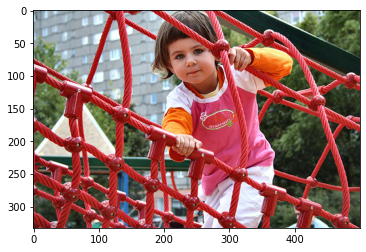

['a child playing on a rope net ',
 'a little girl climbing on red roping ',
 'a little girl in pink climbs a rope bridge at the park ',
 'a small child grips onto the red ropes at the playground ',
 'the small child climbs on a red ropes on a playground ']

In [13]:
# Example: the dataset Nth picture and its preprocessed captions:
Nth = 5
pic_id = list(descriptions.keys())[Nth]
img = plt.imread(images_path + pic_id + ".jpg")
plt.imshow(img)
plt.show()
descriptions[pic_id]

In [14]:
# Creating a vocabulary set of all the unique words.
# These words present across all the 8000*5=40000 image captions in the data set.
vocabulary = set()
for key in descriptions.keys():
  [vocabulary.update(d.split()) for d in descriptions[key]]
print('We have %d unique words across all the 40000 image captions.\n' % len(vocabulary))
# Saving the cleaned tokens on drive as txt file:
lines = list()
for key, desc_list in descriptions.items():
  for desc in desc_list:
    lines.append(key + ' ' + desc)
new_descriptions = '\n'.join(lines)
with open('token.txt', 'w') as f:
  f.write(new_descriptions)
print("Cleaned tokens are saved to drive as token.txt file.")

We have 8828 unique words across all the 40000 image captions.

Cleaned tokens are saved to drive as token.txt file.


In [15]:
# loading all the 6000 training image id’s in a variable train from the ‘Flickr_8k.trainImages.txt’ file:
doc = open(train_images_path,'r').read()
dataset = list()
for line in doc.split('\n'):
  if len(line) > 1:
    identifier = line.split('.')[0]
    dataset.append(identifier)
train = set(dataset)

# Save all the training and testing image files in train_img and test_img lists respectively:
imgs = glob.glob(images_path + '*.jpg')
# traing images:
train_images = set(open(train_images_path, 'r').read().strip().split('\n'))
train_img = []
for img in imgs:
  if img[len(images_path):] in train_images:
    train_img.append(img)
# test images:
test_images = set(open(test_images_path, 'r').read().strip().split('\n'))
test_img = []
for img in imgs:
  if img[len(images_path):] in test_images: 
    test_img.append(img)

# Load the descriptions of the training images into a dictionary.
# We should add starting and ending tokens here.
st_token = "startseq"
en_token = "endseq"
train_descriptions = dict()
for line in new_descriptions.split('\n'):
  tokens = line.split()
  image_id, image_desc = tokens[0], tokens[1:]
  if image_id in train:
    if image_id not in train_descriptions:
      train_descriptions[image_id] = list()
    desc = st_token + ' ' + ' '.join(image_desc) + ' ' + en_token
    train_descriptions[image_id].append(desc)

# Creating a list of all the training captions:
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)

# Reduce vocabularies to only those words which occur at least 10 times in the entire corpus.
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1
vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]

print('Remained vocabulary count = %d' % (len(vocab)))

Remained vocabulary count = 1659


In [16]:
# Creating of two dictionaries to map words to an index and vice versa.
# We also append 1 to our vocabulary since we append 0’s to make all 
# captions of equal length. Now our total vocabulary size is 1660.
ixtoword = {}
wordtoix = {}
for ix, w in enumerate(vocab):
    wordtoix[w] = ix + 1
    ixtoword[ix + 1] = w
vocab_size = len(ixtoword) + 1
# The max length of all captions (We cannot have captions of arbitrary length):
all_desc = list()
for key in train_descriptions.keys():
    [all_desc.append(d) for d in train_descriptions[key]]
lines = all_desc
max_length = max(len(d.split()) for d in lines)
print('The longest caption Length: %d' % max_length)

The longest caption Length: 38


In [17]:
# Word vectors map words to a vector space, where similar words are 
# clustered together and different words are separated.
embeddings_index = {} 
with open(os.path.join(glove_path, 'glove.6B.200d.txt'), encoding="utf-8") as f:
  for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
# Making the matrix of shape (1660,200) consisting of our vocabulary and the 200-d vector.
embedding_dim = 200
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in wordtoix.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

Below cell gonna take a little while (10 minutes) to encode the images by using of InveptionV3 module:

In [18]:
# Transfer learning by using of InceptionV3 which is pre-trained on the ImageNet dataset.
model = InceptionV3(weights='imagenet')
# We do not need to classify the images here.
# Hence we remove the softmax layer from the inceptionV3 model.
model_new = Model(model.input, model.layers[-2].output)

# Since we are using InceptionV3 we need to pre-process our input before
# feeding it into the model. Hence we define a preprocess function to reshape 
# the images to (299 x 299) and feed to the preprocess_input() function of Keras.
def preprocess(image_path):
  img = image.load_img(image_path, target_size=(299, 299))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  return x
# Encoding of training and testing images (extract the images vectors of shape (2048,))
def encode(image):
  image = preprocess(image) 
  fea_vec = model_new.predict(image) 
  fea_vec = np.reshape(fea_vec, fea_vec.shape[1])
  return fea_vec

print("\nEncoding Train images...")
encoding_train = {}
for img in train_img:
  encoding_train[img[len(images_path):]] = encode(img)
train_features = encoding_train
print("Encoding Test images...")
encoding_test = {}
for img in test_img:
  encoding_test[img[len(images_path):]] = encode(img)
print("Encoding finished.")


Encoding Train images...
Encoding Test images...
Encoding finished.


In [19]:
# NN Model will have 3 major steps:
# 1- Processing the sequence from the text 
# 2- Extracting the feature vector from the image
# 3- Decoding the output using softmax by concatenating the above two layers

# Input_1 is the image vector extracted by our InceptionV3 network. It is followed
# by a dropout of 0.5 to avoid overfitting and then fed into a Fully Connected layer.
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# Input_2 is the partial caption of max length 34 which is fed into the embedding
# layer. This is where the words are mapped to the 200-d Glove embedding. It is 
# followed by a dropout of 0.5 to avoid overfitting. This is then fed into the
# LSTM for processing the sequence.
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

# Both the Image model and the Language model are then concatenated by adding 
# and fed into another Fully Connected layer.
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
# The last FC layer is a softmax layer that provides probabilities to our 1660 word vocabulary.
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.summary()

# We do not want to retrain the weights in our embedding layer (pre-trained Glove vectors).
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False
model.compile(loss='categorical_crossentropy', optimizer='adam')

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 38)]         0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 38, 200)      332000      ['input_4[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_3[0][0]']                
                                                                                            

In [21]:
# Since our dataset has 6000 images and 40000 captions we will create a function that can train the data in batches.
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
  X1, X2, y = list(), list(), list()
  n=0
  # loop for ever over images
  while 1:
    for key, desc_list in descriptions.items():
      n+=1
      # retrieve the photo feature
      photo = photos[key+'.jpg']
      for desc in desc_list:
        # encode the sequence
        seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
        # split one sequence into multiple X, y pairs
        for i in range(1, len(seq)):
          # split into input and output pair
          in_seq, out_seq = seq[:i], seq[i]
          # pad input sequence
          in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
          # encode output sequence
          out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
          # store
          X1.append(photo)
          X2.append(in_seq)
          y.append(out_seq)
      if n==num_photos_per_batch:
        yield ([array(X1), array(X2)], array(y))
        X1, X2, y = list(), list(), list()
        n=0

# As the model generates a 1660 long vector with a probability distribution across
# all the words in the vocabulary we greedily pick the word with the highest 
# probability to get the next word prediction. This method is called Greedy Search.
def greedySearch(photo):
  in_text = 'startseq'
  for i in range(max_length):
    sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
    sequence = pad_sequences([sequence], maxlen=max_length)
    yhat = model.predict([photo,sequence], verbose=0)
    yhat = np.argmax(yhat)
    word = ixtoword[yhat]
    in_text += ' ' + word
    if word == 'endseq':
      break
  final = in_text.split()
  final = final[1:-1]
  final = ' '.join(final)
  return final

# Beam Search is where we take top k predictions, feed them again in the model 
# and then sort them using the probabilities returned by the model. So, the list
# will always contain the top k predictions and we take the one with the highest
# probability and go through it till we encounter ‘endseq’ or reach the maximum
# caption length.
def beam_search_predictions(image, beam_index = 3):
  start = [wordtoix["startseq"]]
  start_word = [[start, 0.0]]
  while len(start_word[0][0]) < max_length:
    temp = []
    for s in start_word:
      par_caps = sequence.pad_sequences([s[0]], maxlen=max_length, padding='post')
      preds = model.predict([image,par_caps], verbose=0)
      word_preds = np.argsort(preds[0])[-beam_index:]
      # Getting the top <beam_index>(n) predictions and creating a 
      # new list so as to put them via the model again
      for w in word_preds:
        next_cap, prob = s[0][:], s[1]
        next_cap.append(w)
        prob += preds[0][w]
        temp.append([next_cap, prob])
    start_word = temp
    # Sorting according to the probabilities
    start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
    # Getting the top words
    start_word = start_word[-beam_index:]
  start_word = start_word[-1][0]
  intermediate_caption = [ixtoword[i] for i in start_word]
  final_caption = []
  for i in intermediate_caption:
    if i != 'endseq':
      final_caption.append(i)
    else:
      break
  final_caption = ' '.join(final_caption[1:])
  return final_caption

In [22]:
# Train model:
epochs = 20
batch_size = 100
steps = len(train_descriptions)//batch_size

generator = data_generator(train_descriptions, train_features, wordtoix, max_length, batch_size)
model.fit(generator, epochs=epochs, steps_per_epoch=steps, verbose=1)

Epoch 1/20
60/60 [==============================] - 27s 386ms/step - loss: 5.1069
Epoch 2/20
60/60 [==============================] - 23s 387ms/step - loss: 4.1110
Epoch 3/20
60/60 [==============================] - 23s 391ms/step - loss: 3.6511
Epoch 4/20
60/60 [==============================] - 24s 393ms/step - loss: 3.3955
Epoch 5/20
60/60 [==============================] - 23s 390ms/step - loss: 3.2267
Epoch 6/20
60/60 [==============================] - 27s 446ms/step - loss: 3.0990
Epoch 7/20
60/60 [==============================] - 24s 399ms/step - loss: 3.0021
Epoch 8/20
60/60 [==============================] - 24s 395ms/step - loss: 2.9244
Epoch 9/20
60/60 [==============================] - 24s 393ms/step - loss: 2.8600
Epoch 10/20
60/60 [==============================] - 23s 391ms/step - loss: 2.8067
Epoch 11/20
60/60 [==============================] - 23s 390ms/step - loss: 2.7586
Epoch 12/20
60/60 [==============================] - 24s 401ms/step - loss: 2.7170
Epoch 13/20
6

In [26]:
def generate_picture_caption(Nth):
  pic = list(encoding_test.keys())[Nth]
  image = encoding_test[pic].reshape((1,2048))
  x=plt.imread(images_path+pic)
  plt.imshow(x)
  plt.show()
  print("Greedy Search:", greedySearch(image))
  K = [3, 5, 7, 10]
  for k in K:
    print("Beam Search, K =", str(k)+":", beam_search_predictions(image, beam_index = k))
  print("\n")

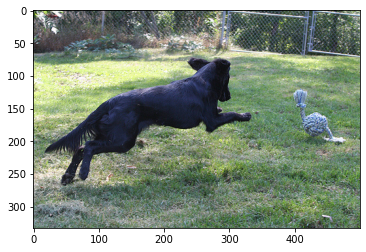

Greedy Search: a black dog is jumping into the air to catch a tennis ball in its mouth
Beam Search, K = 3: a black dog is playing with a tennis ball in the snow
Beam Search, K = 5: a black dog is playing with a tennis ball in its mouth
Beam Search, K = 7: a black dog jumps into the air to catch a tennis ball in its mouth
Beam Search, K = 10: a black dog jumps into the air to catch a tennis ball in its mouth




In [27]:
generate_picture_caption(5)

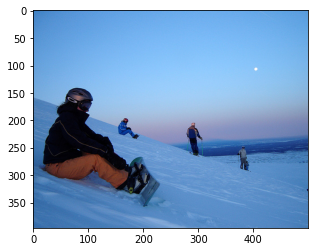

Greedy Search: a man is laying on a snowy hill with a blue backpack in the background
Beam Search, K = 3: a man in a red jacket is laying on a snow covered mountain
Beam Search, K = 5: a group of people play in the snow near a snowy day
Beam Search, K = 7: a group of people play in the snow on a snowy day
Beam Search, K = 10: a group of people play in the snow on a snowy day




In [28]:
generate_picture_caption(10)

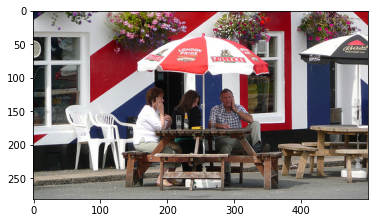

Greedy Search: a man is sitting on a bench in front of a building
Beam Search, K = 3: a group of people are sitting on a bench in front of a building
Beam Search, K = 5: a group of people are sitting on a bench in front of a building
Beam Search, K = 7: a group of people sitting on a bench in front of a building
Beam Search, K = 10: a group of people sit on a bench in front of a painted building




In [29]:
generate_picture_caption(20)

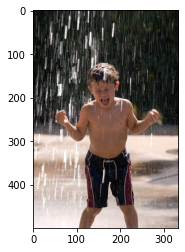

Greedy Search: a young boy wearing a pink swimsuit is jumping into a puddle
Beam Search, K = 3: a young boy wearing a pink bathing suit is jumping into the water
Beam Search, K = 5: a young boy in a pink bathing suit plays in the water
Beam Search, K = 7: a young boy plays in the water
Beam Search, K = 10: a young boy playing in a sprinkler




In [34]:
generate_picture_caption(30)